In [196]:
import json
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

import alpaca
from alpaca.trading.client import TradingClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.stream import TradingStream
from alpaca.data.live.stock import StockDataStream

from alpaca.data.requests import (
    StockBarsRequest,
    StockTradesRequest,
    StockQuotesRequest
)
from alpaca.trading.requests import (
    GetAssetsRequest, 
    MarketOrderRequest, 
    LimitOrderRequest, 
    StopOrderRequest, 
    StopLimitOrderRequest, 
    TakeProfitRequest, 
    StopLossRequest, 
    TrailingStopOrderRequest, 
    GetOrdersRequest, 
    ClosePositionRequest
)
from alpaca.trading.enums import ( 
    AssetStatus, 
    AssetExchange, 
    OrderSide, 
    OrderType, 
    TimeInForce, 
    OrderClass, 
    QueryOrderStatus
)
from alpaca.common.exceptions import APIError

from sklearn.preprocessing import StandardScaler
import pandas as pd
from xgboost import XGBClassifier

In [197]:
api_key = ""
secret_key = ""

paper = True 

# Below are the variables for development this documents
# Please do not change these variables
trade_api_url = None
trade_api_wss = None
data_api_url = None
stream_data_wss = None

# Fetching Market Data

In [198]:
# setup stock historical data client
stock_historical_data_client = StockHistoricalDataClient(api_key, secret_key, url_override = data_api_url)

In [199]:
symbols = ['META', 'AAPL', 'MSFT', 'AMZN', 'GOOG']
now = datetime.now(ZoneInfo("America/New_York"))
start_date = datetime(2021, 3, 1)
end_date = datetime(2024, 3, 1) 
train_percent = 0.66

In [200]:
train_dict = {}
val_dict = {}
for symbol in symbols:
    print(f"Fetching {symbol} data...")
    req = StockBarsRequest(
        symbol_or_symbols = [symbol],
        timeframe=TimeFrame(amount = 5, unit = TimeFrameUnit.Minute), 
        start = start_date,     
        end=end_date,                                                        
    )
    df = stock_historical_data_client.get_stock_bars(req).df.loc[:,["close","volume"]]
    train_cutoff = int(len(df) * 0.66)
    train_dict[symbol] = df.iloc[:train_cutoff]
    val_dict[symbol] = df.iloc[train_cutoff:]

Fetching META data...
Fetching AAPL data...
Fetching MSFT data...
Fetching AMZN data...
Fetching GOOG data...


# Technical Indicator Functions

In [201]:
def calculate_bollinger_bands(data, window=24, num_of_std=2):
    """Calculate Bollinger Bands ratio wrt current price"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    bb_ratio = (data - rolling_mean) / (rolling_std * num_of_std)
    return bb_ratio


In [202]:
def calculate_rsi(data, window=24):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [203]:
def calculate_sma(data, window=24):
    """Calculate SMA ratio of current price."""
    rolling_mean = data.rolling(window=window).mean()
    sma = (data / rolling_mean) - 1
    return sma

In [204]:
def calculate_obv(data):
    # Initialize OBV series with the same index as the DataFrame
    obv = [0]
    
    # Loop through each row in the DataFrame
    for i in range(1, len(data)):
        if data['close'].iloc[i] > data['close'].iloc[i - 1]:
            # Price went up, add the volume
            obv.append(obv[-1] + data['volume'].iloc[i])
        elif data['close'].iloc[i] < data['close'].iloc[i - 1]:
            # Price went down, subtract the volume
            obv.append(obv[-1] - data['volume'].iloc[i])
        else:
            # Price stayed the same, OBV remains unchanged
            obv.append(obv[-1]) 
    return obv


In [205]:
def calculate_ema(data, window = 24):
    """Calculate EMA ratio of current price."""
    rolling_mean = data.ewm(span=window, adjust=False).mean()
    ema = (data / rolling_mean) - 1
    return ema

In [206]:
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the MACD line, Signal line, and MACD Histogram.
    """
    # Calculate the short and long EMAs
    short_ema = prices.ewm(span=short_window, adjust=False).mean()
    long_ema = prices.ewm(span=long_window, adjust=False).mean()
    
    # Calculate the MACD line
    macd_line = short_ema - long_ema
    
    # Calculate the Signal line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    
    # Calculate the MACD Histogram
    macd_histogram = macd_line - signal_line
    
    # Combine the results in a DataFrame
    macd_df = pd.DataFrame({
        'MACD': macd_line,
        'Signal': signal_line,
        'Histogram': macd_histogram
    })
    
    return macd_df
    

# Label Generation Functions

In [207]:
def bollinger_detection(bb, thresh = 1):
    """
    Assign labels based on bollinger band crossings.
    """
    # Initialize the result list with zeros
    crossings = [0] * len(bb)
    
    # Loop through each element, starting from the second element (index 1)
    for i in range(1, len(bb)):
        # Check for -1 crossing: previous value <= -1 and current value > -1
        if bb.iloc[i-1] <= -thresh and bb.iloc[i] > -thresh:
            crossings[i] = 1
        # Check for 1 crossing: previous value >= 1 and current value < 1
        elif bb.iloc[i-1] >= thresh and bb.iloc[i] < thresh:
            crossings[i] = 2
    
    return pd.Series(crossings, index=bb.index)

In [208]:
def rsi_detection(rsi, low_thresh = 30, high_thresh = 70):
    """
    Assign labels based on RSI crossings.
    """
    # Initialize the result list with zeros
    crossings = [0] * len(rsi)
    
    # Loop through each element, starting from the second element (index 1)
    for i in range(1, len(rsi)):
        # Check for low crossing: previous value <= low_thresh and current value > low_thresh
        if rsi.iloc[i-1] <= low_thresh and rsi.iloc[i] > low_thresh:
            crossings[i] = 1
        # Check for high crossing: previous value >= 1 and current value < 1
        elif rsi.iloc[i-1] >= high_thresh and rsi.iloc[i] < high_thresh:
            crossings[i] = 2
    
    return pd.Series(crossings, index=rsi.index)

In [209]:
def generate_labels(df):
    """
    Generate trading labels for algorithm. 0 = hold, 1 = buy, 2 = sell.
    """
    labels_bb = bollinger_detection(df["bb"])
    labels_rsi = rsi_detection(df["rsi"])
    
    labels_final = pd.Series(
        [val if val == labels_bb.iloc[i] else 0 for i, val in enumerate(labels_rsi)],
        index=labels_rsi.index
    )
    
    return labels_final
    

# Generating Feature Tables

In [210]:
for data in (train_dict, val_dict):
    for symbol in symbols:
        # Calc indicators / features
        data[symbol].loc[:,'bb'] = calculate_bollinger_bands(data[symbol]['close'])
        data[symbol].loc[:,'sma'] = calculate_sma(data[symbol]['close'])
        data[symbol].loc[:,'rsi'] = calculate_rsi(data[symbol]['close'])
        data[symbol].loc[:,'obv'] = calculate_obv(data[symbol])
        data[symbol].loc[:,'ema'] = calculate_ema(data[symbol]['close'])
        macd_df = calculate_macd(data[symbol]['close'])
        data[symbol] = pd.concat([data[symbol], macd_df], axis=1)
        # Generate Labels
        labels_df = data[symbol].shift(periods=-2)
        data[symbol].loc[:,'label'] = generate_labels(labels_df)


/var/folders/n7/6dc74jz519j8dyp5j1j8fnlc0000gn/T/ipykernel_28566/3851424453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[symbol].loc[:,'bb'] = calculate_bollinger_bands(data[symbol]['close'])
/var/folders/n7/6dc74jz519j8dyp5j1j8fnlc0000gn/T/ipykernel_28566/3851424453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[symbol].loc[:,'sma'] = calculate_sma(data[symbol]['close'])
/var/folders/n7/6dc74jz519j8dyp5j1j8fnlc0000gn/T/ipykernel_28566/3851424453.py:6: SettingWithCopyWarning: 
A value 

In [211]:
# Stack all dataframes
train_df = pd.concat(train_dict.values(), ignore_index=True)
val_df = pd.concat(val_dict.values(), ignore_index=True)
# Drop NaN
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)

In [212]:
# Optional Normalization (Depending on Model)

In [213]:
n_buy = (train_df['label'] == 1).sum()
n_sell = (train_df['label'] == 2).sum()
print(f"{n_buy} total train buy labels") 
print(f"{n_sell} total train sell labels")

n_buy = (val_df['label'] == 1).sum()
n_sell = (val_df['label'] == 2).sum()
print(f"{n_buy} total val buy labels") 
print(f"{n_sell} total val sell labels")

1077 total train buy labels
1084 total train sell labels
516 total val buy labels
582 total val sell labels


In [144]:
train_df.describe()

,close,volume,bb,sma,rsi,obv,ema,MACD,Signal,Histogram,label
count,394800.000000,3.948000e+05,394800.000000,394800.000000,394800.000000,3.948000e+05,394800.000000,394800.000000,394800.000000,394800.000000,394800.000000
mean,675.538464,2.589891e+05,0.012124,-0.000111,50.319588,-3.699833e+07,-0.000198,-0.089227,-0.089263,0.000036,0.008219
std,1059.263017,9.564433e+05,0.667402,0.010680,13.243614,9.997956e+07,0.011886,6.340815,5.979078,1.888210,0.116804
min,81.560000,1.000000e+02,-2.347398,-0.947375,0.035592,-3.721736e+08,-0.945314,-646.265089,-566.521320,-283.018504,0.000000
25%,134.690000,2.896000e+03,-0.495780,-0.001895,41.262136,-8.593835e+07,-0.001673,-0.195201,-0.188139,-0.057846,0.000000
50%,196.201200,2.215800e+04,0.018687,0.000051,50.367340,-1.462094e+07,0.000057,0.006103,0.006045,0.000043,0.000000
75%,325.991250,2.538450e+05,0.520903,0.001988,59.421856,2.060111e+07,0.001720,0.202111,0.193798,0.058992,0.000000
max,3771.070000,1.140076e+08,2.345302,0.163511,98.360656,2.459361e+08,0.145623,127.556568,112.574445,84.081994,2.000000


In [145]:
train_df.corr()

,close,volume,bb,sma,rsi,obv,ema,MACD,Signal,Histogram,label
close,1.000000,-0.117549,-0.003043,0.005833,0.004031,0.150583,0.008715,0.006656,0.007027,0.000100,0.000199
volume,-0.117549,1.000000,0.002664,0.004113,0.001560,-0.019318,0.003781,0.003006,0.002963,0.000711,0.012261
bb,-0.003043,0.002664,1.000000,0.358977,0.747410,0.001391,0.276624,0.134085,0.096192,0.145675,0.037825
sma,0.005833,0.004113,0.358977,1.000000,0.376095,-0.000219,0.861827,0.817369,0.706184,0.508659,0.013040
rsi,0.004031,0.001560,0.747410,0.376095,1.000000,0.007840,0.297566,0.210718,0.191602,0.100900,0.032934
obv,0.150583,-0.019318,0.001391,-0.000219,0.007840,1.000000,-0.001329,-0.001307,-0.001386,-0.000002,0.001230
ema,0.008715,0.003781,0.276624,0.861827,0.297566,-0.001329,1.000000,0.870059,0.842974,0.252450,0.010760
MACD,0.006656,0.003006,0.134085,0.817369,0.210718,-0.001307,0.870059,1.000000,0.954705,0.335005,0.004714
Signal,0.007027,0.002963,0.096192,0.706184,0.191602,-0.001386,0.842974,0.954705,1.000000,0.039471,0.003583
Histogram,0.000100,0.000711,0.145675,0.508659,0.100900,-0.000002,0.252450,0.335005,0.039471,1.000000,0.004484


# Model Development

In [214]:
from xgboost import XGBClassifier

In [215]:
X_train = train_df.drop(columns=['label']).reset_index(drop=True)
y_train = train_df['label'].reset_index(drop=True)
X_test = val_df.drop(columns=['label']).reset_index(drop=True)
y_test = val_df['label'].reset_index(drop=True)

In [216]:
X_train

,close,volume,bb,sma,rsi,obv,ema,MACD,Signal,Histogram
0,260.630,3921.0,-0.614514,-0.002262,40.358744,15285.0,-0.001663,-0.269090,-0.178763,-0.090327
1,260.500,3818.0,-0.681262,-0.002602,39.215686,11467.0,-0.001988,-0.274709,-0.197952,-0.076756
2,260.920,16339.0,-0.232147,-0.000868,41.753653,27806.0,-0.000349,-0.242476,-0.206857,-0.035619
3,261.050,3993.0,-0.083759,-0.000311,46.004320,31799.0,0.000137,-0.204089,-0.206304,0.002215
4,260.500,5331.0,-0.596663,-0.002280,41.601562,26468.0,-0.001813,-0.215562,-0.208155,-0.007407
...,...,...,...,...,...,...,...,...,...,...
394795,105.815,145783.0,1.070527,0.003238,52.469072,-79542684.0,0.003068,0.054346,0.005136,0.049210
394796,105.755,105007.0,0.861975,0.002653,51.010714,-79647691.0,0.002298,0.067263,0.017561,0.049702
394797,105.670,140545.0,0.564785,0.001788,54.013271,-79788236.0,0.001373,0.069837,0.028016,0.041820
394798,105.758,149369.0,0.765779,0.002547,54.929725,-79638867.0,0.002030,0.078077,0.038028,0.040049


In [217]:
class_weights = y_train.value_counts(normalize=True)  # Get class distribution
total_samples = len(y_train)
scale_pos_weight = total_samples / (len(class_weights) * class_weights)
print(scale_pos_weight)

label
0    1.323243e+05
2    4.792959e+07
1    4.824111e+07
Name: proportion, dtype: float64


In [218]:
model = XGBClassifier(eval_metric='mlogloss', n_estimators = 100)

model.fit(X_train, y_train, sample_weight=y_train.map(scale_pos_weight))


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [219]:
y_preds = model.predict(X_test)

In [220]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision, recall, and F1 score (averaging by 'macro', 'micro', or 'weighted')
precision = precision_score(y_test, y_preds, average='weighted')
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_preds)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.93
Precision: 0.99
Recall: 0.93
F1 Score: 0.96

Confusion Matrix:
[[187853   6852   7526]
 [   239    277      0]
 [   289      0    293]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    202231
           1       0.04      0.54      0.07       516
           2       0.04      0.50      0.07       582

    accuracy                           0.93    203329
   macro avg       0.36      0.66      0.37    203329
weighted avg       0.99      0.93      0.96    203329



# Market Simulations

## Single Holding

In [154]:
# Initialize portfolio values
cash = 10000  # Starting cash
shares_owned = 0
initial_value = cash  # Keep track of the initial portfolio value
df = val_dict['META']
df.dropna(inplace=True)
df.drop(columns=['label'], inplace = True)
df.reset_index(inplace=True, drop=True)
# Simulate trading strategy
for index, row in df.iterrows():
    current_price = row['close']

    # Example trading strategy: Buy if the price is lower than a threshold, sell if higher
    action = model.predict(pd.DataFrame([row]))

    if action == 1 and cash >= current_price:
        # Buy 1 share
        shares_owned += 1
        cash -= current_price
        print(f"Buying 1 share at ${current_price:.2f} on {index}")

    elif action == 2 and shares_owned > 0:
        # Sell 1 share
        shares_owned -= 1
        cash += current_price
        print(f"Selling 1 share at ${current_price:.2f} on {index}")

# Calculate the final portfolio value
final_value = cash + shares_owned * current_price
print(f"\nInitial Portfolio Value: ${initial_value:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
portfolio_return = (final_value - initial_value) / initial_value * 100
print(f"Portfolio Return: {portfolio_return:.2f}%")

Buying 1 share at $169.56 on 186
Buying 1 share at $169.45 on 218
Selling 1 share at $170.15 on 244
Buying 1 share at $169.09 on 280
Buying 1 share at $169.20 on 281
Selling 1 share at $170.49 on 285
Selling 1 share at $170.90 on 292
Selling 1 share at $174.30 on 333
Buying 1 share at $174.45 on 410
Buying 1 share at $174.55 on 411
Buying 1 share at $174.41 on 413
Buying 1 share at $174.25 on 414
Buying 1 share at $174.12 on 443
Buying 1 share at $174.11 on 444
Buying 1 share at $174.12 on 448
Buying 1 share at $174.85 on 490
Buying 1 share at $174.50 on 493
Buying 1 share at $174.60 on 494
Buying 1 share at $174.55 on 495
Buying 1 share at $174.25 on 496
Buying 1 share at $174.26 on 498
Buying 1 share at $174.04 on 503
Selling 1 share at $176.78 on 515
Selling 1 share at $176.85 on 518
Selling 1 share at $177.56 on 522
Selling 1 share at $177.56 on 523
Buying 1 share at $175.20 on 559
Buying 1 share at $174.84 on 560
Buying 1 share at $174.74 on 572
Buying 1 share at $174.54 on 573
Bu

## Multiple Holdings

In [324]:
def generate_BT_data(data, symbols):
    for symbol in symbols:
        # Calc indicators / features
        data[symbol].loc[:,'bb'] = calculate_bollinger_bands(data[symbol]['close'])
        data[symbol].loc[:,'sma'] = calculate_sma(data[symbol]['close'])
        data[symbol].loc[:,'rsi'] = calculate_rsi(data[symbol]['close'])
        data[symbol].loc[:,'obv'] = calculate_obv(data[symbol])
        data[symbol].loc[:,'ema'] = calculate_ema(data[symbol]['close'])
        macd_df = calculate_macd(data[symbol]['close'])
        data[symbol] = pd.concat([data[symbol], macd_df], axis=1)
        data[symbol].dropna(inplace=True)
    return data


In [325]:
def preprocess_BT_data(historical_data):
    """ Reset df index & remove duplicate rows. """
    for symbol, df in historical_data.items():
        # Reset the index to turn multi-index into columns
        df = df.reset_index()
        
        # Set 'timestamp' as the single index
        df = df.set_index('timestamp')
        df.drop(columns = 'symbol',inplace=True)

        if df.index.duplicated().any():
            # Remove duplicates, keeping only the first occurrence of each timestamp
            df = df[~df.index.duplicated(keep='first')]
        
        # Update the dictionary with the modified dataframe
        historical_data[symbol] = df
    return historical_data



In [326]:
# Define portfolio settings
symbols = ['AAPL', 'MSFT']  # Multiple stock symbols
start_date = '2023-05-01'
end_date = '2024-05-01'

# Fetch historical data for each stock
historical_data = {}
for symbol in symbols:
    req = StockBarsRequest(
        symbol_or_symbols = [symbol],
        timeframe=TimeFrame(amount = 5, unit = TimeFrameUnit.Minute), 
        start = start_date,     
        end=end_date,                                                        
    )
    historical_data[symbol] = stock_historical_data_client.get_stock_bars(req).df.loc[:,["close","volume"]]

In [327]:
historical_data = generate_BT_data(historical_data, symbols)

In [328]:
historical_data = preprocess_BT_data(historical_data)

In [242]:
# Align timestamps
#timestamps_sets = {name: set(df.index.get_level_values('timestamp')) for name, df in historical_data.items()}

# Find common timestamps across all DataFrames
#common_timestamps = set.intersection(*timestamps_sets.values())

# Filter each DataFrame to only include rows with these common timestamps
#filtered_historical_data = {}
#for name, df in historical_data.items():
#    filtered_historical_data[name] = df[df.index.get_level_values('timestamp').isin(common_timestamps)]


In [243]:
#for symbol, df in historical_data.items():
#    # Reset the index to turn multi-index into columns
#    df = df.reset_index()
#    
    # Set 'timestamp' as the single index
#    df = df.set_index('timestamp')
#    df.drop(columns = 'symbol',inplace=True)
#    
#    # Update the dictionary with the modified dataframe
#    historical_data[symbol] = df


In [285]:
#for symbol, df in historical_data.items():
#    # Check if there are any duplicate timestamps in the index
#    if df.index.duplicated().any():
#        # Remove duplicates, keeping only the first occurrence of each timestamp
#        historical_data[symbol] = df[~df.index.duplicated(keep='first')]

In [331]:
initial_cash = 10000

cash_allocation = {
    'AAPL': 0.5,  # 50% of cash allocated to AAPL
    'MSFT': 0.5   # 50% of cash allocated to MSFT
}

# Initialize portfolio variables
portfolio = {
    'cash': {symbol: initial_cash * cash_allocation[symbol] for symbol in symbols},
    'positions': {symbol: {'shares': 0, 'value': 0} for symbol in symbols},
    'history': []
}

In [332]:
# Run the simulation
for date in historical_data[symbols[0]].index:  # Assumes all stocks have the same dates
    portfolio_value = sum(portfolio['cash'].values())
    
    for symbol in symbols:
        stock_data = historical_data[symbol]
        
        if date in stock_data.index:
            current_price = stock_data.at[date, 'close']
            row_data = stock_data.loc[date].to_frame().T.reset_index(drop=True)  # Prepare row data for prediction
            action = model.predict(row_data)

            # Buy logic
            if action == 1:
                max_shares_to_buy = portfolio['cash'][symbol] / current_price
                if max_shares_to_buy > 0:
                    portfolio['positions'][symbol]['shares'] += max_shares_to_buy
                    portfolio['cash'][symbol] -= max_shares_to_buy * current_price
                    print(f"Buying {max_shares_to_buy:.4f} shares of {symbol} at ${current_price:.2f} on {date}")

            # Sell logic
            elif action == 2:
                shares_held = portfolio['positions'][symbol]['shares']
                if shares_held > 0:
                    portfolio['positions'][symbol]['shares'] = 0
                    portfolio['cash'][symbol] += shares_held * current_price
                    print(f"Selling {shares_held:.4f} shares of {symbol} at ${current_price:.2f} on {date}")
            
            # Update position value
            shares = portfolio['positions'][symbol]['shares']
            portfolio['positions'][symbol]['value'] = shares * current_price
            portfolio_value += portfolio['positions'][symbol]['value']

    # Record daily portfolio value
    portfolio['history'].append({'date': date, 'portfolio_value': portfolio_value})

# Calculate the final portfolio return
initial_value = initial_cash
final_value = portfolio['history'][-1]['portfolio_value']
portfolio_return = (final_value - initial_value) / initial_value * 100

# Print summary
print(f"\nInitial Portfolio Value: ${initial_value:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Portfolio Return: {portfolio_return:.2f}%")


Buying 16.3132 shares of MSFT at $306.50 on 2023-05-01 11:50:00+00:00
Selling 16.3132 shares of MSFT at $307.75 on 2023-05-01 16:35:00+00:00
Buying 16.4103 shares of MSFT at $305.93 on 2023-05-01 18:30:00+00:00
Buying 29.5142 shares of AAPL at $169.41 on 2023-05-01 18:35:00+00:00
Selling 29.5142 shares of AAPL at $169.64 on 2023-05-02 08:05:00+00:00
Selling 16.4103 shares of MSFT at $306.30 on 2023-05-02 08:25:00+00:00
Buying 29.6155 shares of AAPL at $169.06 on 2023-05-02 14:15:00+00:00
Selling 29.6155 shares of AAPL at $168.87 on 2023-05-02 17:20:00+00:00
Buying 29.7034 shares of AAPL at $168.37 on 2023-05-02 21:35:00+00:00
Selling 29.7034 shares of AAPL at $168.79 on 2023-05-03 08:05:00+00:00
Buying 16.3834 shares of MSFT at $306.80 on 2023-05-03 12:55:00+00:00
Selling 16.3834 shares of MSFT at $307.31 on 2023-05-03 17:05:00+00:00
Buying 29.6858 shares of AAPL at $168.89 on 2023-05-03 19:10:00+00:00
Buying 16.5227 shares of MSFT at $304.72 on 2023-05-03 19:30:00+00:00
Selling 16.522

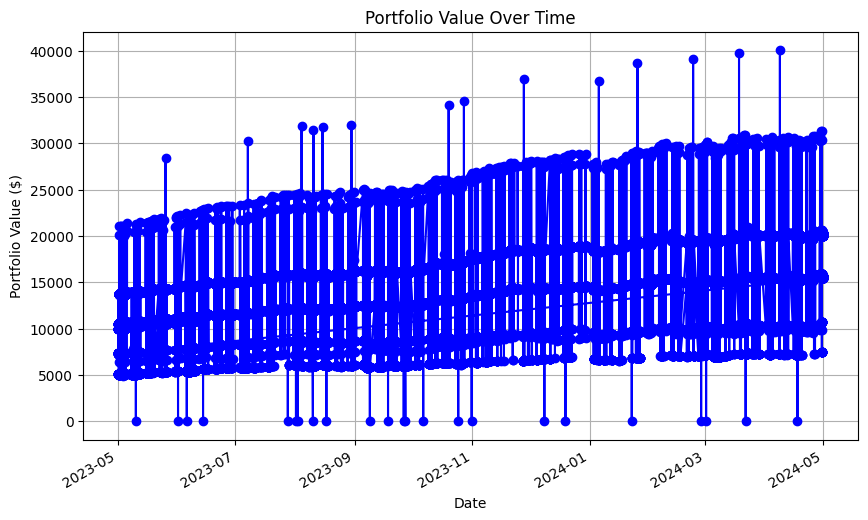

In [291]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert portfolio history to a DataFrame
history_df = pd.DataFrame(portfolio['history'])

# Set 'date' as the index for better plotting
history_df.set_index('date', inplace=True)

# Plot
history_df['portfolio_value'].plot(figsize=(10, 6), color='blue', marker='o', title='Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()
